In [ ]:
"""
Module for setting up a stateful AI agent using LangGraph and LangChain.

This module defines a reactive AI agent using LangGraph's state management 
and LangChain's AI models. It includes tools for document processing, 
vector storage, and financial data retrieval.
"""

In [1]:
import os
from typing import Literal, List, Union, Annotated, Sequence
from langgraph.types import Command
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict
from langchain_core.messages import AIMessage
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from tools_list import (
    income_statement_tool,
    balance_sheet_tool,
    cashflow_tool,
    finance_ratio_tool,
    retriever_tool,
    housing_price_index_tool,
)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
AZURE_GPT_API = os.getenv("AZURE_GPT_API")
AZURE_GPT_ENDPOINT = os.getenv("AZURE_GPT_ENDPOINT")
try:
    model = AzureChatOpenAI(
        azure_endpoint=AZURE_GPT_ENDPOINT,
        azure_deployment="gpt-4o",
        api_version="2024-08-01-preview",
        api_key=AZURE_GPT_API,
        temperature=0.2,
        streaming=True,
    )
except Exception as e:
    raise RuntimeError(f"Failed to initialize AzureChatOpenAI: {e}") from e

In [3]:
# Define available agents
members = ["Fundamental_Analysis_Agent",
            "Sentiment_Analysis_Agent",
            "Technical_Analysis_Agent",
            "Risk_Assessment_Agent",
            "Real_Estate_Agent"]

In [4]:
# Define router type for structured output
class Router(TypedDict):
    """Worker to route to next."""
    next_worker: List[Literal["Fundamental_Analysis_Agent", "Sentiment_Analysis_Agent", "Technical_Analysis_Agent", "Risk_Assessment_Agent",
                              "Real_Estate_Agent"]]
    
class ConversationalResponse(TypedDict):
    """Respond in a conversational manner. Be kind and helpful."""
    response: Annotated[str, ..., "A conversational response to the user's query"]

In [5]:
class FinalResponse(TypedDict):
    """
    Represents the final output of a system, which can either be:
    
    Router type, determining the next worker to handle the process.
    ConversationalResponse type, providing a user-friendly response.
    """
    final_output: Union[Router, ConversationalResponse]

In [6]:
# Router Agent
web_search_tool = TavilySearchResults(max_results=2)
router_agent_tools = [web_search_tool]
ROUTER_AGENT_PROMPT = (
    "You are a high-level coordinator in a multi-agent financial advisory system. "
    "Your role is to determine which specialized agent(s) should handle the user's query. "
    "Available agents are: {members}. Based on the user's intent, delegate the task accordingly. "
    "\n\nRouting rules:\n"
    "- If the user asks about company fundamentals (e.g., income statement, balance sheet, cash flow, or financial ratios), route to 'Fundamental_Analysis_Agent'.\n"
    "- If the query requires technical indicators like SMA, RSI, MACD, or price trends, route to 'Technical_Analysis_Agent'.\n"
    "- If the user wants to understand market sentiment or public opinion around a stock, route to 'Sentiment_Analysis_Agent'.\n"
    "- If the query involves understanding the investment risk or volatility of a stock, route to 'Risk_Assessment_Agent'.\n"
    "- If the query relates to housing prices or real estate in Sweden, route to 'Real_Estate_Agent'.\n"
    "- If the question is general or conversational, provide a direct natural-language response.\n\n"
    "Respond with either a list of agent names (for routing) or a conversational answer (if general)."
)
router_agent = create_react_agent(
    model, tools=router_agent_tools, prompt=ROUTER_AGENT_PROMPT, response_format=FinalResponse
)

In [7]:
def router_node(state: MessagesState):
    """
    Determines the next agent or endpoint based on the user's query.

    This function processes the current conversation state, invokes the
    routing model, and decides whether to route the query to the Finance
    Agent, News Agent, or terminate the process.

    Args:
        state (MessagesState): The current conversation state containing messages.

    Returns:
        messages: Extracts last message of AIMessage Object.
    """
    try:
        global response
        response = router_agent.invoke(state)
        print("\nThis is from router node: ", response)
        structured_response = state.get("structured_response", {})
        print(f"Structured Response: {structured_response}")
        final_output = structured_response.get("final_output", {})
        next_workers = final_output.get("next_worker", [])
        output = response["messages"][-1].content
        print(f"Next Worker: {next_workers}")
        if output == ["FINISH"]:
            output = END
        return {"messages": [
                     AIMessage(content=response["messages"][-1].content, name="Router_Agent")
                 ]}
    except Exception as e:
        print(f"Error in router_node: {e}")
        return END

In [8]:
# Finance Agent
fundamental_analysis_agent_tools = [income_statement_tool, balance_sheet_tool, cashflow_tool, finance_ratio_tool]
FUNDAMENTAL_ANALYSIS_AGENT_PROMPT = (
    "You are a financial analyst focused on company fundamentals. "
    "Using the available tools (balance sheet, income statement, cash flow statement, and key financial ratios from yfinance), "
    "analyze the stock ticker mentioned by the user. Identify strengths, weaknesses, and overall financial health based on the data. "
    "If the user asks specific financial questions (e.g., 'What is the debt-to-equity ratio?' or 'Is revenue growing?'), provide clear answers. "
    "Be precise, use financial terminology where appropriate, and explain briefly when necessary."
)

fundamental_analysis_agent = create_react_agent(model, tools=fundamental_analysis_agent_tools, prompt=FUNDAMENTAL_ANALYSIS_AGENT_PROMPT)

In [9]:
def fundamental_node(state: MessagesState):
    """
    Processes financial queries and updates the conversation state.

    This function invokes the Fundamental Analysis Agent to handle financial queries,
    updates the conversation state with the agent's response, and directs
    the flow to the Final Agent.

    Args:
        state (MessagesState): The current conversation state.

    Returns:
        Command: A command updating the conversation and routing to the Final Agent.
    """
    try:
        result = fundamental_analysis_agent.invoke(state)
        #print("\nThis is from fundamental node -before command: ",result)
        command = Command(
            update={
                "messages": [
                    AIMessage(
                        content=result["messages"][-1].content, name="Fundamental_Analysis_Agent"
                    )
                ]
            },
            goto="Final_Agent",
        )
        #print("\nThis is from fundamental node: ", command)
        return command
    except Exception as e:
        print(f"Error in fundamental_node: {e}")
        return Command(goto=END)

In [10]:
sentiment_analysis_agent_tools = [retriever_tool]
SENTIMENT_ANALYSIS_AGENT_PROMPT = (
    "You are a sentiment analysis specialist. Your task is to analyze recent public sentiment about a specific stock ticker. "
    "You are provided with the latest three news articles retrieved via yfinance and indexed using a RAG system. "
    "Interpret the sentiment in these documents (positive, negative, neutral) and summarize any major themes or opinions. "
    "If the sentiment is mixed, explain both sides. Provide a clear summary of how the stock is being perceived currently."
)

sentiment_analysis_agent = create_react_agent(model, tools=sentiment_analysis_agent_tools, prompt=SENTIMENT_ANALYSIS_AGENT_PROMPT)

In [11]:
def sentiment_node(state: MessagesState):
    """
    Processes news-related queries and updates the conversation state.

    This function invokes the Sentiment Analysis Agent to determine the sentiment
    of news articles related to the user's query on stock tickers,
    updates the conversation state with the agent's response, and routes
    the flow to the Final Agent.

    Args:
        state (MessagesState): The current conversation state.

    Returns:
        Command: A command updating the conversation and routing to the Final Agent.
    """
    try:
        result = sentiment_analysis_agent.invoke(state)
        command = Command(
            update={
                "messages": [
                    AIMessage(content=result["messages"][-1].content, name="Sentiment_Analysis_Agent")
                ]
            },
            goto="Final_Agent",
        )
        #print("\nThis is from sentiment node: ", command)
        return command
    except Exception as e:
        print(f"Error in sentiment_node: {e}")
        return Command(goto=END)

In [12]:
technical_analysis_agent_tools = []
TECHNICAL_ANALYSIS_AGENT_PROMPT = (
    "You are a technical analyst responsible for analyzing the stock ticker's recent performance using historical price data. "
    "Using the last 1 year of price history (retrieved from yfinance), compute and interpret key indicators such as:"
    "\n- Simple Moving Averages (SMA)\n- Relative Strength Index (RSI)\n- Moving Average Convergence Divergence (MACD)\n"
    "Use these to identify trends, overbought/oversold conditions, momentum shifts, or buy/sell signals. "
    "Explain your insights clearly, as if advising an investor unfamiliar with the raw numbers."
)

technical_analysis_agent = create_react_agent(model, tools=technical_analysis_agent_tools, prompt=TECHNICAL_ANALYSIS_AGENT_PROMPT)

In [13]:
def technical_node(state: MessagesState):
    """
    Processes news-related queries and updates the conversation state.

    This function invokes the Technical Analysis Agent to handle the technical details of stock ticker
    using RSI, MACD and SMA indicators, updates the conversation state with the agent's response, 
    and routes the flow to the Final Agent.

    Args:
        state (MessagesState): The current conversation state.

    Returns:
        Command: A command updating the conversation and routing to the Final Agent.
    """
    try:
        result = technical_analysis_agent.invoke(state)
        command = Command(
            update={
                "messages": [
                    AIMessage(content=result["messages"][-1].content, name="Technical_Analysis_Agent")
                ]
            },
            goto="Final_Agent",
        )
        #print("\nThis is from technical node: ", command)
        return command
    except Exception as e:
        print(f"Error in technical_node: {e}")
        return Command(goto=END)

In [14]:
risk_assessment_agent_tools = [retriever_tool]
RISK_ASSESSMENT_AGENT_PROMPT = (
    "You are a risk assessment analyst evaluating the investment risk of a given stock ticker. "
    "Using available financial indicators (such as beta, volatility, debt levels, and valuation ratios from yfinance), "
    "analyze the stock’s potential risk to an investor. Highlight factors such as price fluctuation, debt exposure, and market sensitivity. "
    "If available, include metrics like Beta, daily return volatility, and debt-to-equity ratio. Provide a conclusion on whether the stock "
    "is low, moderate, or high risk — and briefly justify your assessment."
)

risk_assessment_agent = create_react_agent(model, tools=risk_assessment_agent_tools, prompt=RISK_ASSESSMENT_AGENT_PROMPT)

In [15]:
def risk_assessment_node(state: MessagesState):
    """
    Processes news-related queries and updates the conversation state.

    This function invokes the Technical Analysis Agent to handle the technical details of stock ticker
    using RSI, MACD and SMA indicators, updates the conversation state with the agent's response, 
    and routes the flow to the Final Agent.

    Args:
        state (MessagesState): The current conversation state.

    Returns:
        Command: A command updating the conversation and routing to the Final Agent.
    """
    try:
        result = risk_assessment_agent.invoke(state)
        command = Command(
            update={
                "messages": [
                    AIMessage(content=result["messages"][-1].content, name="Risk_Assessment_Agent")
                ]
            },
            goto="Final_Agent",
        )
        #print("\nThis is from risk assessment node: ", command)
        return command
    except Exception as e:
        print(f"Error in risk_assessment_node: {e}")
        return Command(goto=END)

In [16]:
real_estate_agent_tools = [housing_price_index_tool, web_search_tool]
REAL_ESTATE_AGENT_PROMPT = (
    "You are a real estate analyst focused on the Swedish housing market. "
    "Using regional housing price index data retrieved from the SCB API via pyscbwrapper, analyze property trends across Sweden. "
    "When the user specifies a region (e.g., Stockholm, Malmö), provide insights on current price levels, recent trends, and changes over time. "
    "If possible, comment on whether it's a high, low, or stable valuation period for the specified area."
)

real_estate_agent = create_react_agent(model, tools=real_estate_agent_tools, prompt=REAL_ESTATE_AGENT_PROMPT)

In [17]:
def real_estate_node(state: MessagesState):
    """
    Processes housing price-related queries and updates the conversation state.

    This function invokes the Real Estate Agent to handle housing queries,
    updates the conversation state with the agent's response, and routes
    the flow to the Final Agent.

    Args:
        state (MessagesState): The current conversation state.

    Returns:
        Command: A command updating the conversation and routing to the Final Agent.
    """
    try:
        result = real_estate_agent.invoke(state)
        command = Command(
            update={
                "messages": [
                    AIMessage(content=result["messages"][-1].content, name="Real_Estate_Agent")
                ]
            },
            goto="Final_Agent",
        )
        #print("\nThis is from real_estate_node: ", command)
        return command
    except Exception as e:
        print(f"Error in real_estate_node: {e}")
        return Command(goto=END)

In [18]:
FINAL_AGGREGATOR_AGENT_PROMPT = (
    "You are the final response composer in a multi-agent financial advisor system. "
    "Your task is to summarize and consolidate information provided by one or more agents (e.g., Fundamental, Technical, Sentiment, Risk, Real Estate) "
    "into a single clear, well-structured response for the user."
    "\n\nIf multiple agents provide insights, combine them into a cohesive summary. "
    "Avoid repeating data; instead, synthesize the analysis and draw a high-level conclusion. "
    "Make sure the response feels unified, professional, and easy to understand — like advice from a financial consultant."
)
final_agent = create_react_agent(model, tools=[], prompt=FINAL_AGGREGATOR_AGENT_PROMPT)

In [19]:
def final_node(state: MessagesState):
    """
    Aggregates responses from the Finance, News and General agents, passes them to the Final Agent,
    and returns a final summarized result.
    """
    try:
        result = final_agent.invoke(state)
        command = Command(
            update={
                "messages": [
                    AIMessage(
                        content=result["messages"][-1].content, name="Final_Aggregator_Agent"
                    )
                ]
            },
            goto=END,
        )
        #print("\nThis is from final node: ", command)
        return command
    except Exception as e:
        print(f"Error in final_node: {e}")
        return Command(goto=END)

In [20]:

def condition(state: MessagesState) -> Sequence[str]:
    """
    Determines the next agents to route to based on the Router_Agent's structured response.

    Args:
        state (MessagesState): The current state containing message history.

    Returns:
        Sequence[str]: A list of agent names to route to, or ["__end__"] if none are specified.
    """
    try:
        # Access the structured response from the Router_Agent
        print("state from condition:", state)
        #last_message = state["messages"][-1].content
        structured_response = response.get("structured_response", {})
        final_output = structured_response.get("final_output", {})
        next_workers = final_output.get("next_worker", [])

        # Ensure next_workers is a list of strings
        if isinstance(next_workers, list) and all(isinstance(worker, str) for worker in next_workers):
            print(f"from_condition: {next_workers}")
            return next_workers

        return ["__end__"]
    except Exception as e:
        print(f"Error in condition function: {e}")
        return ["__end__"]

In [21]:
memory = MemorySaver()
builder = StateGraph(MessagesState)
builder.add_node("Router_Agent", router_node)
builder.add_node("Fundamental_Analysis_Agent", fundamental_node)
builder.add_node("Sentiment_Analysis_Agent", sentiment_node)
builder.add_node("Technical_Analysis_Agent", technical_node)
builder.add_node("Risk_Assessment_Agent", risk_assessment_node)
builder.add_node("Real_Estate_Agent", real_estate_node)
builder.add_node("Final_Aggregator_Agent", final_node)

In [22]:
builder.add_edge(START, "Router_Agent")
builder.add_conditional_edges("Router_Agent", condition, members)
builder.add_edge("Fundamental_Analysis_Agent", "Final_Aggregator_Agent")
builder.add_edge("Sentiment_Analysis_Agent", "Final_Aggregator_Agent")
builder.add_edge("Technical_Analysis_Agent", "Final_Aggregator_Agent")
builder.add_edge("Risk_Assessment_Agent", "Final_Aggregator_Agent")
builder.add_edge("Real_Estate_Agent", "Final_Aggregator_Agent")
builder.add_edge("Final_Aggregator_Agent", END)

In [23]:
graph = builder.compile(checkpointer=memory)

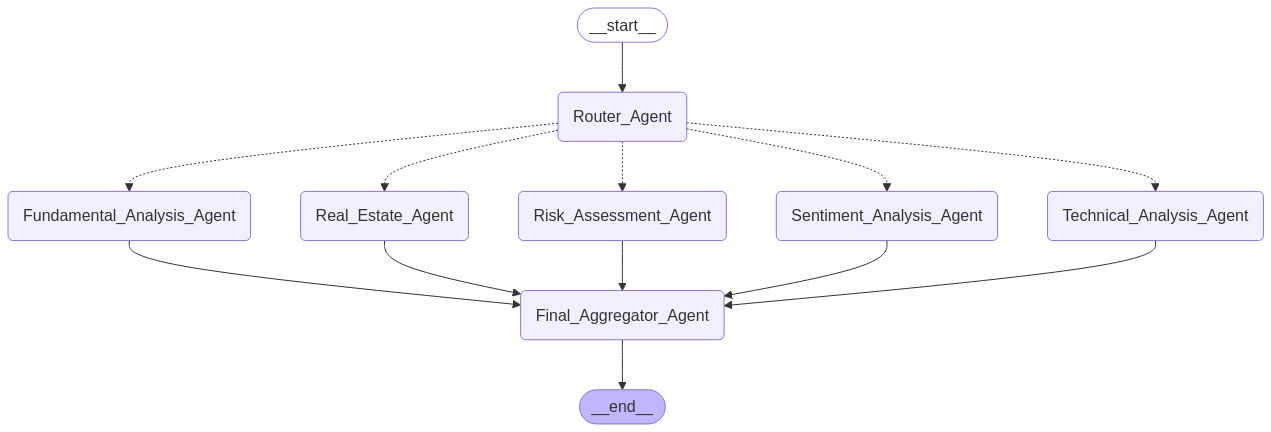

In [24]:
graph

In [25]:
config_1 = {"configurable": {"thread_id": "1"}}
USER_QUESTION_1 = "Give me the analysis of balance sheet for the stock tesla(TSLA)?"
events = graph.stream(
    {"messages": [{"role": "user", "content": USER_QUESTION_1}]},
    config_1,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Give me the analysis of balance sheet for the stock tesla(TSLA)?

This is from router node:  {'messages': [HumanMessage(content='Give me the analysis of balance sheet for the stock tesla(TSLA)?', additional_kwargs={}, response_metadata={}, id='d6be5c11-ed86-4c44-8753-40f37cc6083b'), AIMessage(content='The query involves analyzing the balance sheet of Tesla (TSLA), which falls under company fundamentals. Routing to **Fundamental_Analysis_Agent**.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0'}, id='run-e59e69c2-7a12-4bde-a67e-a46d847649bd-0')], 'structured_response': {'final_output': {'next_worker': ['Fundamental_Analysis_Agent']}}}
Structured Response: {}
Next Worker: []
state from condition: {'messages': [HumanMessage(content='Give me the analysis of balance sheet for the stock tesla(TSLA)?', additional_kwargs={

In [ ]:
config_2 = {"configurable": {"thread_id": "2"}}
USER_QUESTION_2 = "Is it right time to buy house in karlstad?"
events = graph.stream(
    {"messages": [{"role": "user", "content": USER_QUESTION_2}]},
    config_2,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [26]:
config_3 = {"configurable": {"thread_id": "3"}}
USER_QUESTION_3 = "Hi, How are you?"
events = graph.stream(
    {"messages": [{"role": "user", "content": USER_QUESTION_3}]},
    config_3,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, How are you?

This is from router node:  {'messages': [HumanMessage(content='Hi, How are you?', additional_kwargs={}, response_metadata={}, id='ae96aae9-cee6-4d01-9caf-7139d06dfd7e'), AIMessage(content="I'm just a system, so I don't have feelings, but thank you for asking! How can I assist you today?", additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0'}, id='run-f9d41d66-2ff0-416b-a1e3-bff81f83de97-0')], 'structured_response': {'final_output': {'response': "I'm here and ready to assist you! How can I help you today?"}}}
Structured Response: {}
Next Worker: []
state from condition: {'messages': [HumanMessage(content='Hi, How are you?', additional_kwargs={}, response_metadata={}, id='ae96aae9-cee6-4d01-9caf-7139d06dfd7e'), AIMessage(content="I'm just a system, so I don't have feelings, but thank you for asking! How c